In [331]:
import requests, zipfile, io
import pandas as pd
import numpy as np

In [334]:
#CASOS E OBITOS SP
#https://www.saopaulo.sp.gov.br/planosp/simi/dados-abertos/
#https://www.saopaulo.sp.gov.br/wp-content/uploads/2021/04/20210428_Casos-e-obitos-ESP.zip
obitos_sp=pd.read_csv('F:/COVID/20210428_Casos-e-obitos-ESP.zip', compression='zip',sep=';')
obitos_sp['Faixa/Ano']=pd.cut(obitos_sp.Idade,bins=Bins,labels=Labels)
obitos_sp[['Data Inicio Sintomas']]=pd.to_datetime(obitos_sp['Data Inicio Sintomas'], format='%d/%m/%Y')


In [335]:
#Dados de vacinação no OPENDATASUS
#https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao/resource/ef3bd0b8-b605-474b-9ae5-c97390c197a8
#https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/PNI/vacina/uf/2021-04-22/uf%3DSP/part-00000-f4b1298a-67c6-4e3b-ac0a-f4e795f78108.c000.csv
chunks=pd.read_csv('https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/PNI/vacina/uf/2021-04-22/uf%3DSP/part-00000-f4b1298a-67c6-4e3b-ac0a-f4e795f78108.c000.csv',chunksize=100000,sep=';')
vacina_sp=pd.DataFrame()
for chunk in chunks:
    chunk = chunk[['vacina_dataAplicacao','paciente_idade','paciente_enumSexoBiologico','vacina_descricao_dose']]
    chunk.vacina_dataAplicacao=pd.to_datetime(chunk.vacina_dataAplicacao)
    vacina_sp=pd.concat([chunk,vacina_sp])


In [336]:
#Piramide etária para SP segundo projeção do IBGE
#https://www.ibge.gov.br/apps/populacao/projecao//
piramide=pd.read_csv('F:/COVID/piramide_sp_H.csv',sep=';')
piramide.set_index(['Faixa/Ano'],inplace=True)
piramide=piramide[['2021']]
piramide.columns =['Homens']
piramidem=pd.read_csv('F:/COVID/piramide_sp_M.csv',sep=';')
piramidem.set_index(['Faixa/Ano'],inplace=True)
piramidem=piramidem[['2021']]
piramidem.columns =['Mulheres']
piramide['Mulheres']=piramidem.Mulheres
piramide['Total']=piramide.Homens+piramide.Mulheres
piramide.drop(index='Total',inplace=True)
piramide.index.name=None
piramide.head()

,Homens,Mulheres,Total
0-4,1546271,1475765,3022036
5-9,1564228,1494314,3058542
10-14,1509358,1444004,2953362
15-19,1566874,1504113,3070987
20-24,1740281,1689640,3429921


In [342]:
Labels=piramide.index
Bins=[0,4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,89,np.inf]
#vacina_1d=vacina_sp.loc[vacina_sp['vacina_descricao_dose']=='\xa0\xa0\xa0\xa01ª\xa0Dose' ,['paciente_idade','paciente_enumSexoBiologico']].reset_index(drop=True)
vacina_sp['Faixa/Ano']=pd.cut(vacina_sp.paciente_idade,bins=Bins,labels=Labels)
#retira dados que não indicam se primeira ou segunda dose
DOSE=vacina_sp.loc[(vacina_sp.vacina_descricao_dose!='\xa0\xa0\xa0\xa01ª\xa0Dose')&(vacina_sp.vacina_descricao_dose!='\xa0\xa0\xa0\xa02ª\xa0Dose')].index
vacina_sp.drop(index=DOSE,inplace=True)
#homogeinizadados vacinas
vacina_sp.loc[vacina_sp.vacina_descricao_dose.str[4:5]=='1','vacina_descricao_dose']=1
vacina_sp.loc[vacina_sp.vacina_descricao_dose.str[4:5]=='2','vacina_descricao_dose']=2

In [343]:
pivot_vacinas=vacina_sp.pivot_table(values='paciente_idade',index='Faixa/Ano',columns=['vacina_descricao_dose'],aggfunc='count')
pivot_vacinas

vacina_descricao_dose,1,2
Faixa/Ano,,
0-4,62,24
5-9,111,51
10-14,164,75
15-19,19466,9059
20-24,129499,69576
25-29,180743,101713
30-34,216314,120700
35-39,246867,137508
40-44,232081,127861


<AxesSubplot:xlabel='Data Inicio Sintomas'>

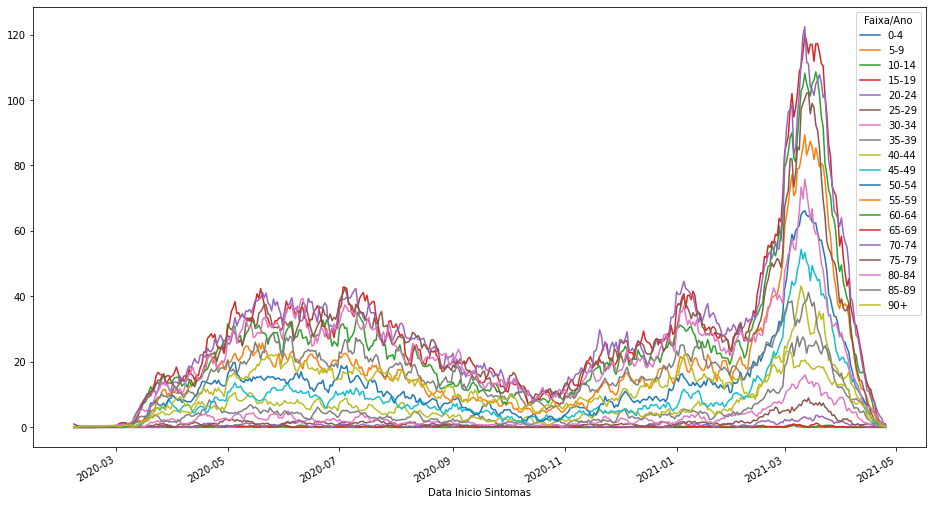

In [344]:
#Evolução dos Óbitos para as faixas etárias
obitos_sp.loc[obitos_sp.Obito!=0][['Idade','Data Inicio Sintomas','Faixa/Ano']].pivot_table(values='Idade',index='Data Inicio Sintomas',columns=['Faixa/Ano'],aggfunc='count').rolling(5, min_periods=1).mean().plot(figsize=(16,9))

<AxesSubplot:xlabel='vacina_dataAplicacao'>

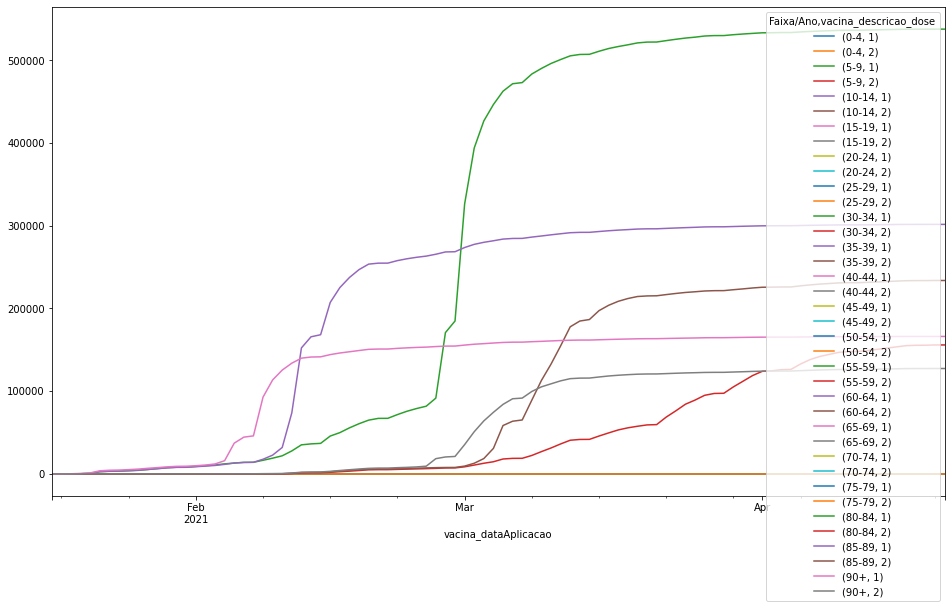

In [345]:
#evolução da vacinação para algumas faixas de idade
vacina_sp.loc[vacina_sp['Faixa/Ano'].isin(['90+','85-89','80-84'])].pivot_table(values='paciente_idade',index='vacina_dataAplicacao',columns=['Faixa/Ano','vacina_descricao_dose'],aggfunc='count').cumsum().plot(figsize=(16,9))

In [346]:
vacina_sp

,vacina_dataAplicacao,paciente_idade,paciente_enumSexoBiologico,vacina_descricao_dose,Faixa/Ano
8400000,2021-04-14 00:00:00+00:00,76,M,2,75-79
8400001,2021-04-03 00:00:00+00:00,68,F,1,65-69
8400002,2021-04-15 00:00:00+00:00,75,F,2,75-79
8400003,2021-04-07 00:00:00+00:00,57,F,2,55-59
8400004,2021-04-02 00:00:00+00:00,68,F,1,65-69
...,...,...,...,...,...
99995,2021-02-17 00:00:00+00:00,42,M,2,40-44
99996,2021-04-02 00:00:00+00:00,68,F,1,65-69
99997,2021-02-18 00:00:00+00:00,54,F,2,50-54
99998,2021-04-15 00:00:00+00:00,69,F,2,65-69


In [19]:
obitos_sp[['Diagnostico Covid19', 'Data Inicio Sintomas','Idade', 'Obito']]

,Diagnostico Covid19,Data Inicio Sintomas,Idade,Obito
61,CONFIRMADO,04/03/2021,41.0,1
177,CONFIRMADO,14/01/2021,96.0,1
203,CONFIRMADO,17/07/2020,82.0,1
245,CONFIRMADO,20/03/2021,46.0,1
263,CONFIRMADO,08/06/2020,58.0,1
...,...,...,...,...
2750109,CONFIRMADO,15/03/2021,53.0,1
2750138,CONFIRMADO,08/01/2021,61.0,1
2750171,CONFIRMADO,25/01/2021,69.0,1
2750183,CONFIRMADO,20/07/2020,76.0,1


In [347]:
obitos_sp['Data Inicio Sintomas']=pd.to_datetime(obitos_sp['Data Inicio Sintomas'])
obitos_sp['ano']=obitos_sp['Data Inicio Sintomas'].dt.year
obitos_sp['Semana']=obitos_sp['Data Inicio Sintomas'].dt.week

In [ ]:
#distribuição de idades para os óbitos Obitos de pessoas no final de julho 2020
obitos_sp.loc[(obitos_sp['ano']==2020) & (obitos_sp['Semana']=='30')].Idade.hist()

<AxesSubplot:>

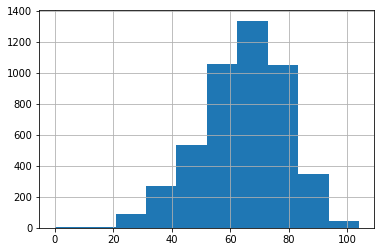

In [61]:
#distribuição de idades para os óbitos de pessoas em março 2021

obitos_sp.loc[(obitos_sp['ano']==2021) & (obitos_sp['Semana']=='11')].Idade.hist()

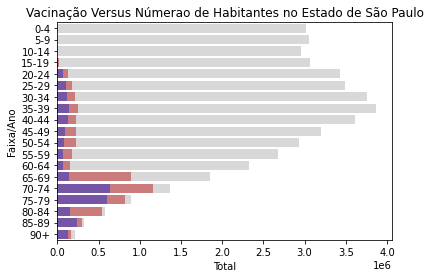

In [368]:
import seaborn as sns
pivot_vacinas.columns.name=None
pivot_vacinas.columns=['1 Dose','2 Dose']
bar_plot = sns.barplot(pivot_vacinas['1 Dose'],pivot_vacinas.index, lw=0,alpha=0.6, color = 'red')
bar_plot = sns.barplot(pivot_vacinas['2 Dose'],pivot_vacinas.index, lw=0,alpha=0.6, color = 'blue')
bar_plot = sns.barplot(piramide['Total'],piramide.index, lw=0,alpha=0.3, color = 'grey')
bar_plot.set_title('Vacinação Versus Númerao de Habitantes no Estado de São Paulo')
bar_plot.figure.savefig('vacinacao_sp.jpg')

In [352]:
pivot_casos=obitos_sp.pivot_table(values='Genero',index='Faixa/Ano',columns=['Diagnostico Covid19'],aggfunc='count')
pivot_casos.columns=['casos']
pivot_obitos=obitos_sp.loc[obitos_sp.Obito==1].pivot_table(values='Genero',index='Faixa/Ano',columns=['Diagnostico Covid19'],aggfunc='count')
pivot_obitos.columns=['obitos']
pivot_total=pivot_vacinas.merge(pivot_casos,how='left',right_index=True,left_index=True).merge(pivot_obitos,how='left',right_index=True,left_index=True).merge(piramide,how='left',right_index=True,left_index=True)
pivot_total['obitos100k']=pivot_total.obitos/pivot_total.Total*100000
pivot_total['casos100k']=pivot_total.casos/pivot_total.Total*100000

In [353]:
#tabela que resume a vacinação até agora, casos e óbitos por faixa etária em São Paulo
pivot_total

,1 Dose,2 Dose,casos,obitos,Homens,Mulheres,Total,obitos100k,casos100k
Faixa/Ano,,,,,,,,,
0-4,62,24,27560,27,1546271,1475765,3022036,0.893437,911.967958
5-9,111,51,35116,26,1564228,1494314,3058542,0.850078,1148.128749
10-14,164,75,50566,39,1509358,1444004,2953362,1.320529,1712.150424
15-19,19466,9059,114339,87,1566874,1504113,3070987,2.832965,3723.200391
20-24,129499,69576,230300,283,1740281,1689640,3429921,8.250919,6714.440362
25-29,180743,101713,274435,600,1765040,1731463,3496503,17.160002,7848.842115
30-34,216314,120700,316384,1216,1900507,1863050,3763557,32.309860,8406.515432
35-39,246867,137508,341721,2105,1922035,1947435,3869470,54.400215,8831.209442
40-44,232081,127861,311882,3020,1764170,1853619,3617789,83.476400,8620.790212


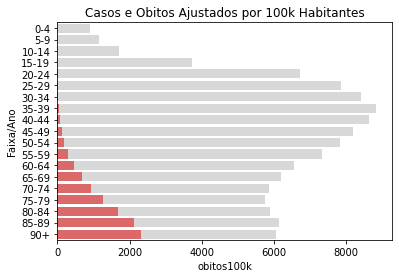

In [357]:
bar_plot2 = sns.barplot(pivot_total['casos100k'],pivot_casos.index, lw=0,alpha=0.3, color = 'grey')
bar_plot2 = sns.barplot(pivot_total['obitos100k'],pivot_casos.index, lw=0,alpha=0.6, color = 'red')
bar_plot2.set_title('Casos e Obitos Ajustados por 100k Habitantes')
bar_plot2.figure.savefig('casos_obitos_100k_sp.jpg')

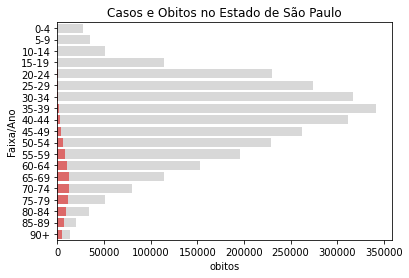

In [364]:
bar_plot2 = sns.barplot(pivot_total['casos'],pivot_casos.index, lw=0,alpha=0.3, color = 'grey')
bar_plot2 = sns.barplot(pivot_total['obitos'],pivot_casos.index, lw=0,alpha=0.6, color = 'red')
bar_plot2.set_title('Casos e Obitos no Estado de São Paulo')
bar_plot2.figure.savefig('casos_obitos_sp.jpg')

In [365]:
pivot_total['1dose100k']=pivot_total['1 Dose']/pivot_total.Total*100
pivot_total['2dose100k']=pivot_total['2 Dose']/pivot_total.Total*100

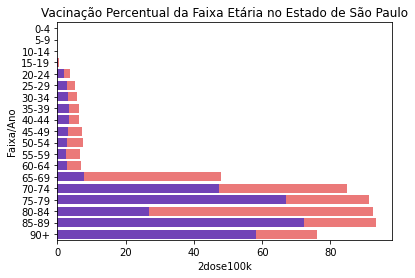

In [367]:
bar_plot2 = sns.barplot(pivot_total['1dose100k'],pivot_casos.index, lw=0,alpha=0.6, color = 'red')
bar_plot2 = sns.barplot(pivot_total['2dose100k'],pivot_casos.index, lw=0,alpha=0.6, color = 'blue')
bar_plot2.set_title('Vacinação Percentual da Faixa Etária no Estado de São Paulo')
bar_plot2.figure.savefig('vacina_100k_sp.jpg')